<h1> Unsupervised Learning on Country Data

## Business Understanding

<h3> Clustering the Countries by using Unsupervised Learning to divide them into 3 major groups </h3>

<strong>Developemnt:</strong>
Find 3 major groups using K-Means and Hierarchical Clustering and find the 3 countries that better define each group. Finally compare the clusterizations of each algorithm.

<strong>Objective:</strong>
To categorise the countries using socio-economic and health factors that determine the overall development of the country.

## Data Understanding

<h3>Data Dictionary:</h3>

`country`: Name of the country

`child_mort`: Death of children under 5 years of age per 1000 live births

`exports`: Exports of goods and services per capita. Given as %age of the GDP per capita

`health`: Total health spending per capita. Given as %age of GDP per capita

`imports`: Imports of goods and services per capita. Given as %age of the GDP per capita

`Income`: Net income per person

`Inflation`: The measurement of the annual growth rate of the Total GDP

`life_expec`: The average number of years a new born child would live if the current mortality patterns are to remain the same

`total_fer`: The number of children that would be born to each woman if the current age-fertility rates remain the same.

`gdpp`: The GDP per capita. Calculated as the Total GDP divided by the total population.


### EDA

In [1]:
# Import libraries
from math import ceil
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.decomposition import PCA
from paretochart import pareto
from yellowbrick.cluster import KElbowVisualizer
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

sns.set_style("darkgrid")
sns.set_context("paper")

palette = ['g', 'm', 'y']

In [2]:
def print_label(label, size=60):
    side = (size - len(label)) // 2
    print('\n' + side * "*" + ' ' + label + ' ' + side * "*" + '\n')

def scatterplot_high_corr(df, hue = 'dev_status', n_cols = 3, palette = palette, figsize = (16,14)):
    fig = plt.figure(figsize=figsize)
    fig.set_tight_layout(True)

    cols = df.columns.drop(['cluster', 'dev_status'], errors='ignore')
    plots = []
    for x in cols:
        for y in cols:
            if x != y and abs(df[x].corr(df[y])) > 0.5:
                    plots.append((x, y))
        cols = cols.drop(x)

    n_rows = ceil(len(plots) / n_cols)
    for i, (x, y) in enumerate(plots, start=1):
        plt.subplot(n_rows, n_cols, i)
        sns.scatterplot(x=x, y=y, data=df, hue=hue, palette=palette)
        plt.title(f'{x.upper()} vs {y.upper()}', fontsize=12)

def plot_components(coeff, ax, labels):
    for idx in range(coeff.shape[0]):
        ax.arrow(0, 0, coeff[idx, 0] * 4, coeff[idx, 1] * 4, head_width=.1, color='r', alpha=0.4)
        ax.text(coeff[idx, 0] * 4.4, coeff[idx, 1] * 4.4 , s=labels[idx], fontdict={'color': 'r', 'fontsize':20}, alpha=0.7)

def plot_PCA(X_pca, df, pca, centroids = None):
    fig, ax = plt.subplots(1, 1, figsize=(18, 18))

    ax.spines["left"].set_position("zero")
    ax.spines["bottom"].set_position("zero")
    ax.spines["right"].set_color("none")
    ax.spines["top"].set_color("none")
    ax.grid(False)

    sns.scatterplot(data=X_pca, x="PC1", y="PC2", ax=ax, alpha=0)
    if centroids is not None:
        sns.scatterplot(data=centroids, x=centroids[:, 0], y=centroids[:, 1], ax=ax, s=200, color='k', marker='X')

    for idx in range(X_pca.shape[0]):
        cluster = df.get('cluster')
        if cluster is not None:
            color = palette[cluster[idx]]
        else:
            color = None
        ax.text(x=X_pca.PC1[idx], y=X_pca.PC2[idx], s=X_pca.index[idx], 
                ha='center', va='center', fontsize=12, color=color)

    plot_components(pca.components_.T, ax, df.columns)

In [3]:
# Import Data Set
countries = pd.read_csv('data/Country-data.csv')

# Visualize the first 5 rows
display(countries.head())

# Check the data types
print_label('DATA SET INFORMATION')
countries.info()

# Check for missing values
print_label('MISSING VALUES')
print(countries.isnull().sum())

# Check for duplicates
print_label('DUPLICATED OBSERVATIONS')
print(countries.duplicated().sum())

# Check data statistics
print_label('FEATURE STATISTICS')
display(countries.describe().round(2))

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200



******************** DATA SET INFORMATION ********************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB

*********************** MISSING VALUES ***********************

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

****************** DUPLICATED OBSERV

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00
mean,38.27,41.11,6.82,46.89,17144.69,7.78,70.56,2.95,12964.16
std,40.33,27.41,2.75,24.21,19278.07,10.57,8.89,1.51,18328.70
min,2.60,0.11,1.81,0.07,609.00,-4.21,32.10,1.15,231.00
25%,8.25,23.80,4.92,30.20,3355.00,1.81,65.30,1.80,1330.00
50%,19.30,35.00,6.32,43.30,9960.00,5.39,73.10,2.41,4660.00
75%,62.10,51.35,8.60,58.75,22800.00,10.75,76.80,3.88,14050.00
max,208.00,200.00,17.90,174.00,125000.00,104.00,82.80,7.49,105000.00


**Analysis:** The Data set is complete, without missing values and duplicates. There are 9 features for each country, some of them showing economical indicators and others showing social indicators. The high variance of the features shows that there's a large difference between the countries in the data set, with some outliers.

---

In [4]:
# Visualize unique values for each feature
for col in countries.columns:
    values = countries[col].unique()
    print(f'{col.upper()}: {countries[col].nunique()} unique values', sorted(values), sep='\n', end='\n\n')

COUNTRY: 167 unique values
['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan',

**Analysis:** Analysing the unique values of each feature shows us that there are 167 Countries in the Data Set, exactly 1 per line. Also we can observe that there are some inconsistent values on `exports` and `imports` that are close to 0.0 and may by some error on the data set, this is worth taking a closer look.

In [5]:
# Check odd values
countries[(countries['exports'] < 1) & (countries['imports'] < 1)]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
107,Myanmar,64.4,0.109,1.97,0.0659,3720,7.04,66.8,2.41,988


**Analysis:** Conducting a quick search online, I found out that those numbers seems inaccurate for Myanmar. Since we don't have the year of this data set, I can't input the correct numbers. In this case, I'll `drop` Myanmar from this data set, to avoid a biased influence on the final reults.

In [6]:
countries = countries.drop(index=107).reset_index(drop=True)

---

In [7]:
countries.set_index('country', inplace=True)

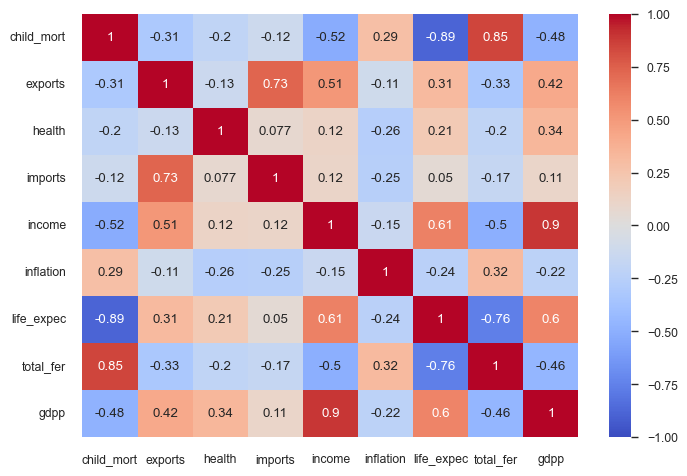

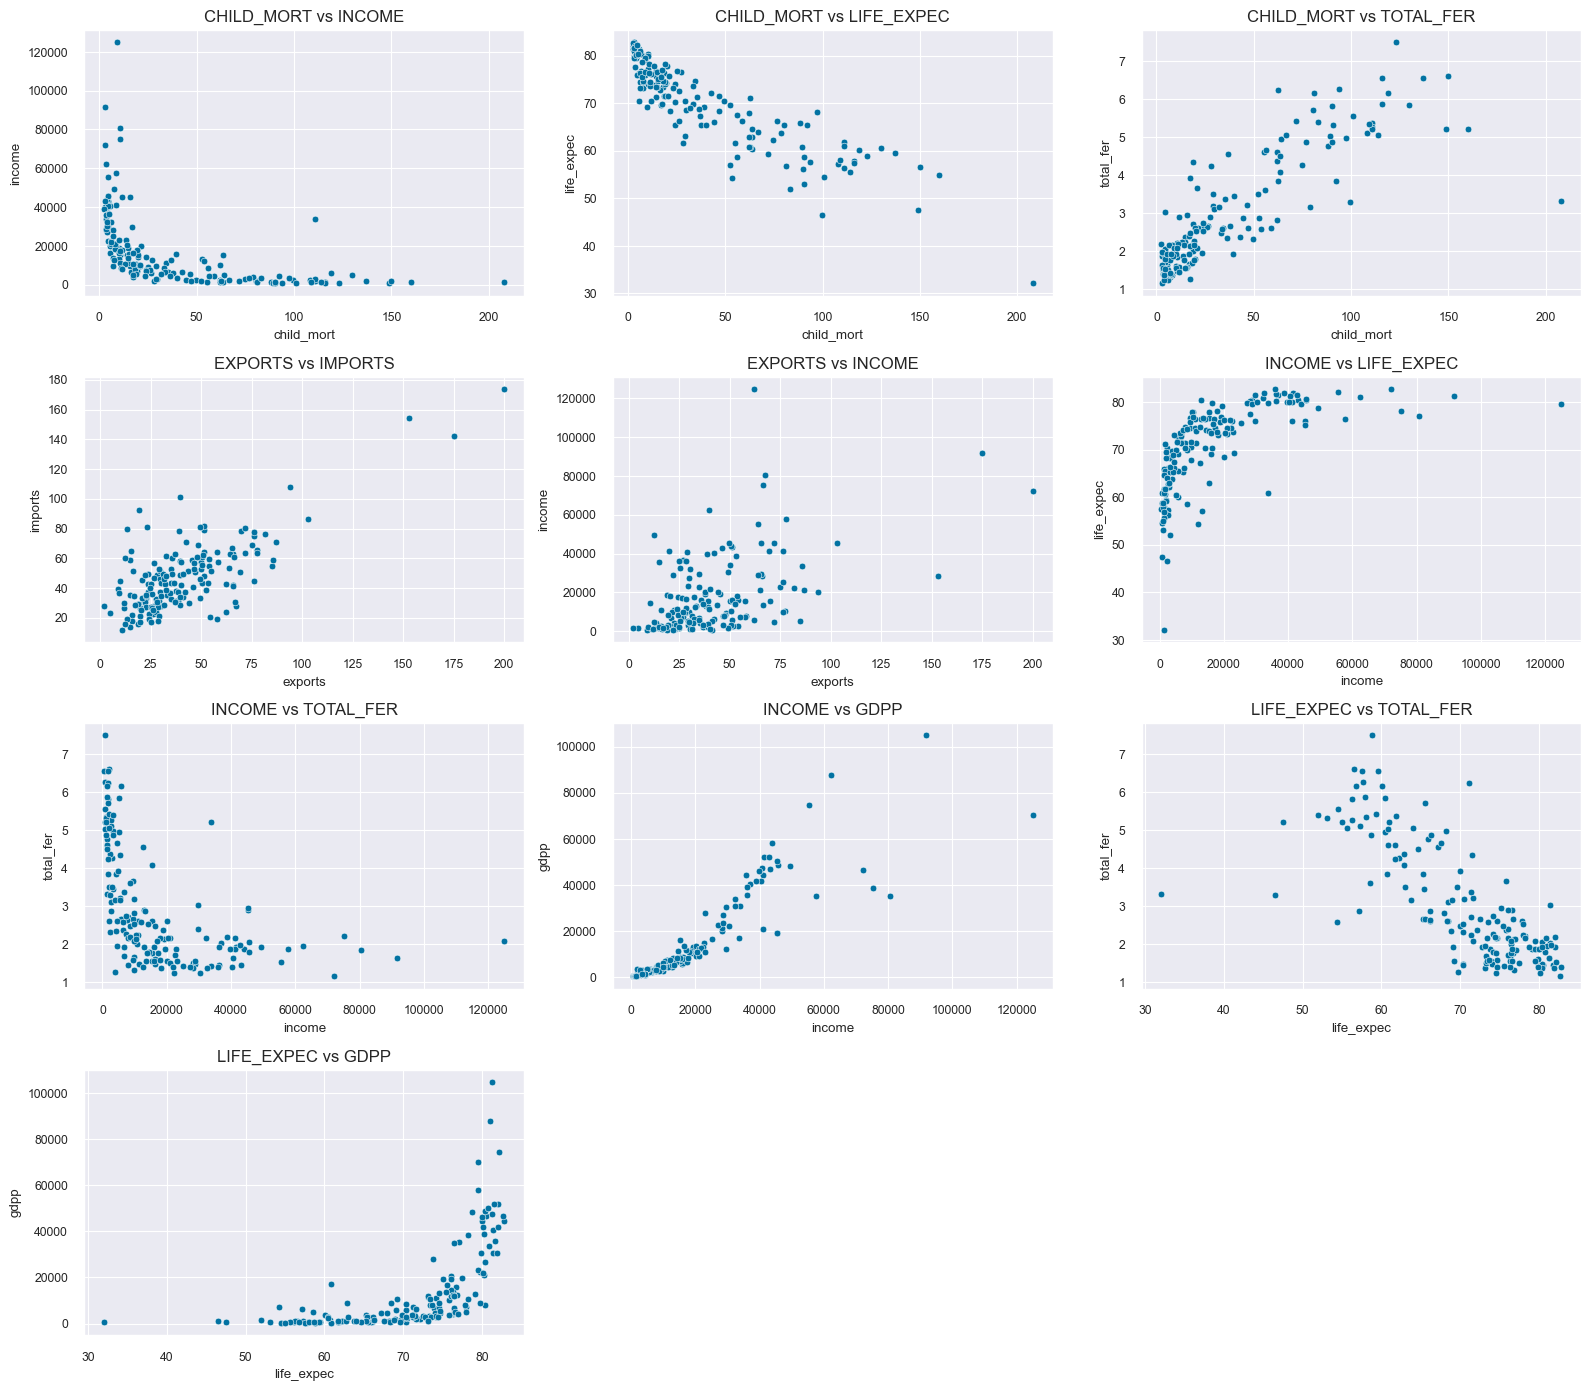

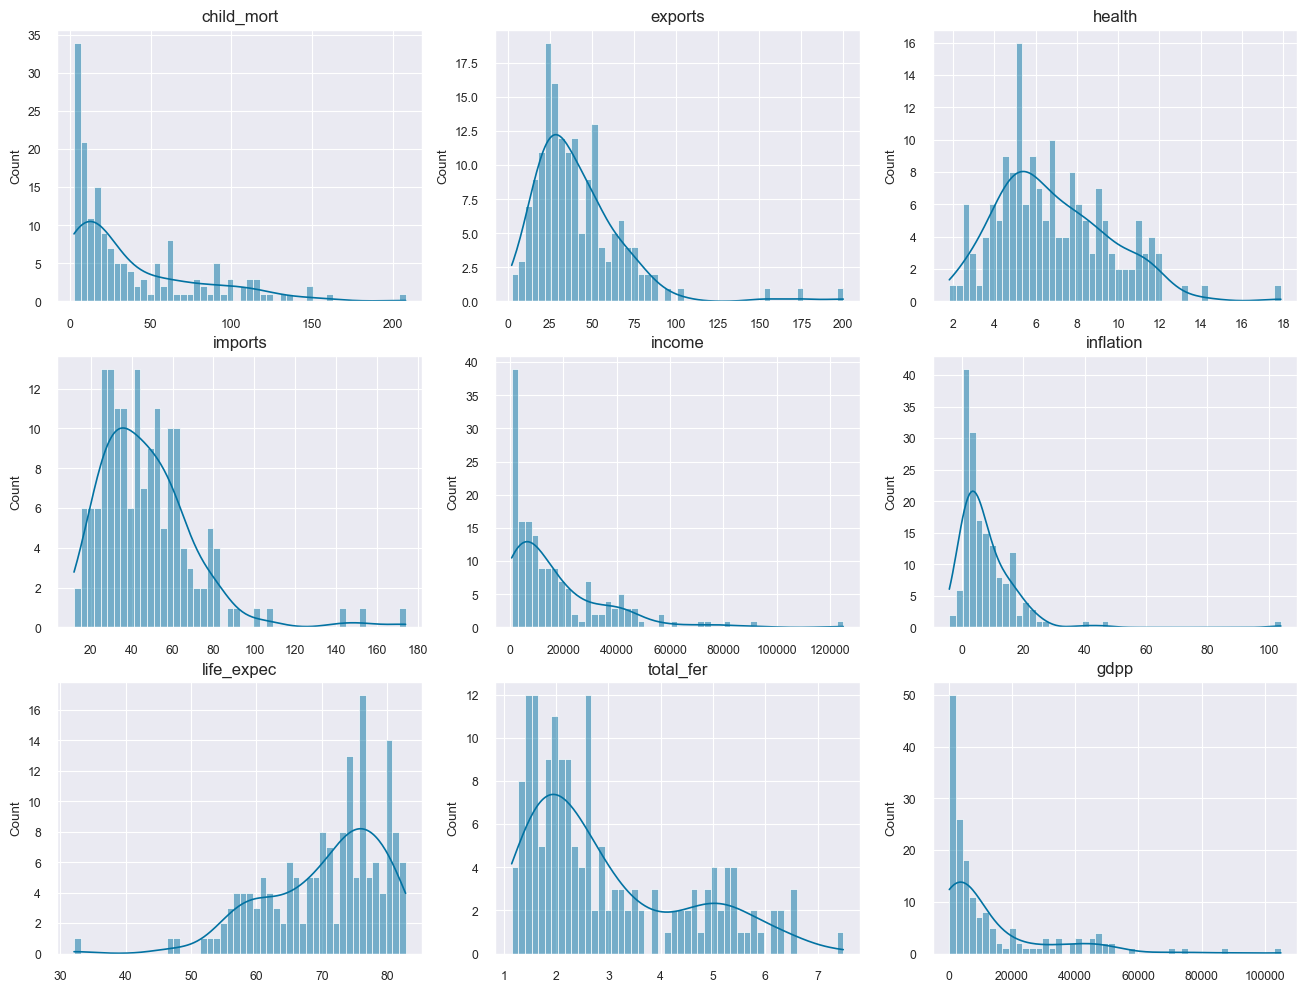

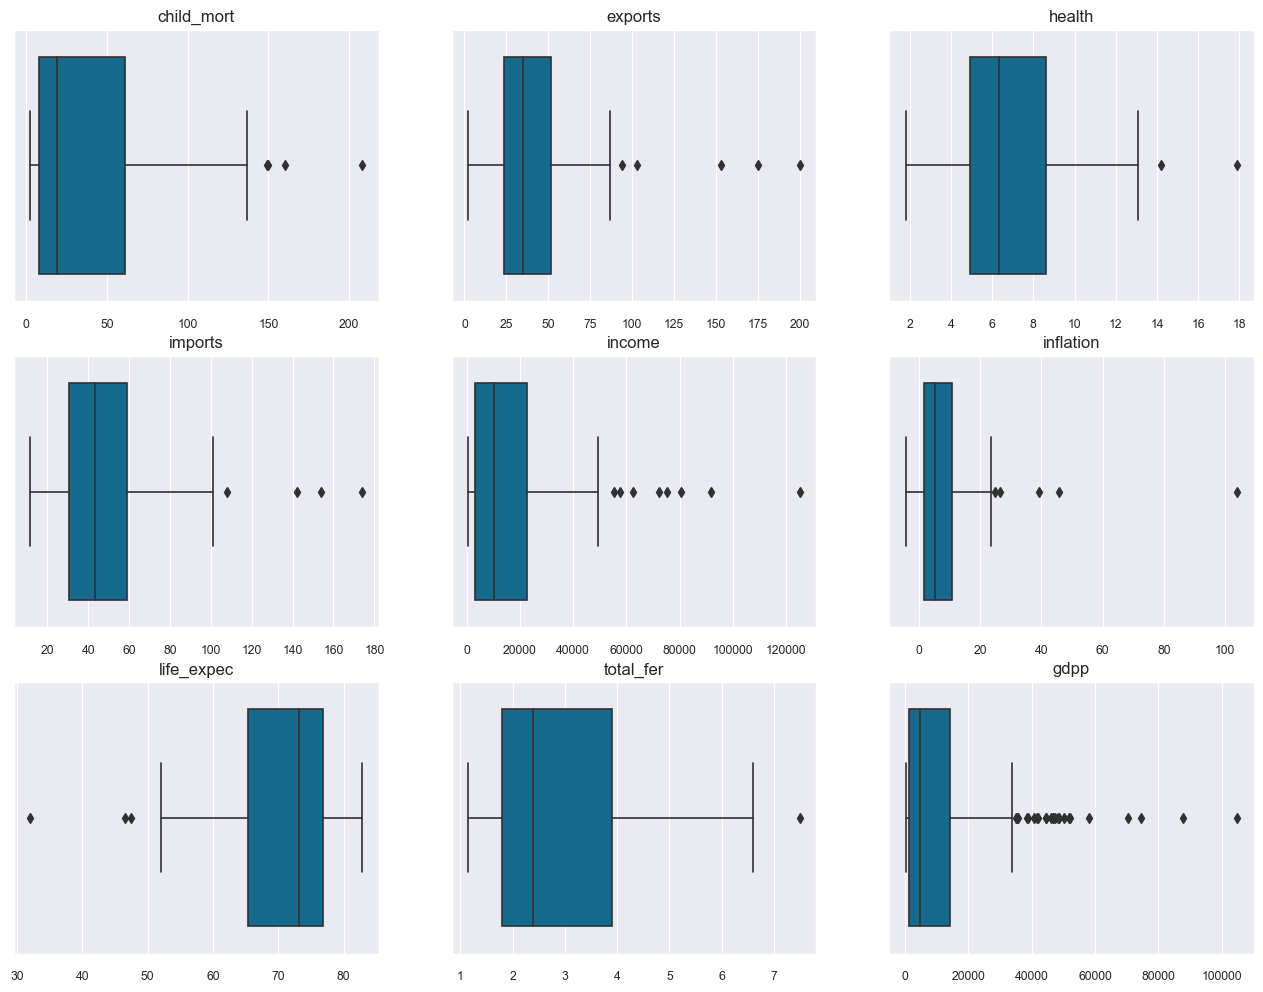

In [8]:
# Visualize correlation between features
# Heatmap
sns.heatmap(countries.corr(), annot=True, vmin=-1, vmax=1, center=0, cmap='coolwarm')
plt.show()

# Scatter Plots
scatterplot_high_corr(countries, hue=None, palette=None)

# Visualize distribution of features
fig, axs = plt.subplots(3, 3, figsize=(16, 12))

for i, col in enumerate(countries.columns, start=1):
    plt.subplot(3, 3, i)
    sns.histplot(x=col, data=countries, bins=50, kde=True)
    plt.xlabel('')
    plt.title(col, fontsize=12)
plt.show()

# Visualize outliers
fig, axs = plt.subplots(3, 3, figsize=(16, 12))

for i, col in enumerate(countries.columns, start=1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=col, data=countries)
    plt.xlabel('')
    plt.title(col, fontsize=12)
plt.show()

**Analysis:** Each graphical visulization above shows us some interesting information about the data set:

- **Heatmap & Scatterplot:** Here we can identify that some of the features have a high correlation, both positive and negative, between them. Such as: gdpp VS income (positive), life expectancy VS child mortality (negative), among others. Remembering that correlation doesn't mean causality, but is certainly something to highlight and take a depper look inside, that's why I plotted the scatterplot of the highest correlations.

- **Histograms with Distribution Curves:** Here we can analyse each variable independently and see their distribution among the data set. The major outcome is that none of them is normally distributed, with almost all, with exception of life expectancy, showing a right-skewed distribution, where the lower values are the most common in the data set. It doesn't necessarily means a good or bad thing, that will depent of the variable itself, for example for child mortality and inflation, the lower the best, but for life expectancy and GDPP it's the opposite. Another important outcome, for improvement of the final results of this analysis, is that we will need to scale those features, since they aren't in the same range and nor in a normal distribution.

- **Box Plots:** Plotting each individual box plot confirms that all the feature are not normally distributed, but on top of that it shows that for every variable there are some outliers. I decided not to remove the outliers, since the data set is already to small and these outliers doesn't seem to reflect any errors on measurements.

## Data Preparation

### Scaling

/Users/brunomotta/miniconda3/envs/bootcamp/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Users/brunomotta/miniconda3/envs/bootcamp/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (166). n_quantiles is set to n_samples.
  warnings.warn(


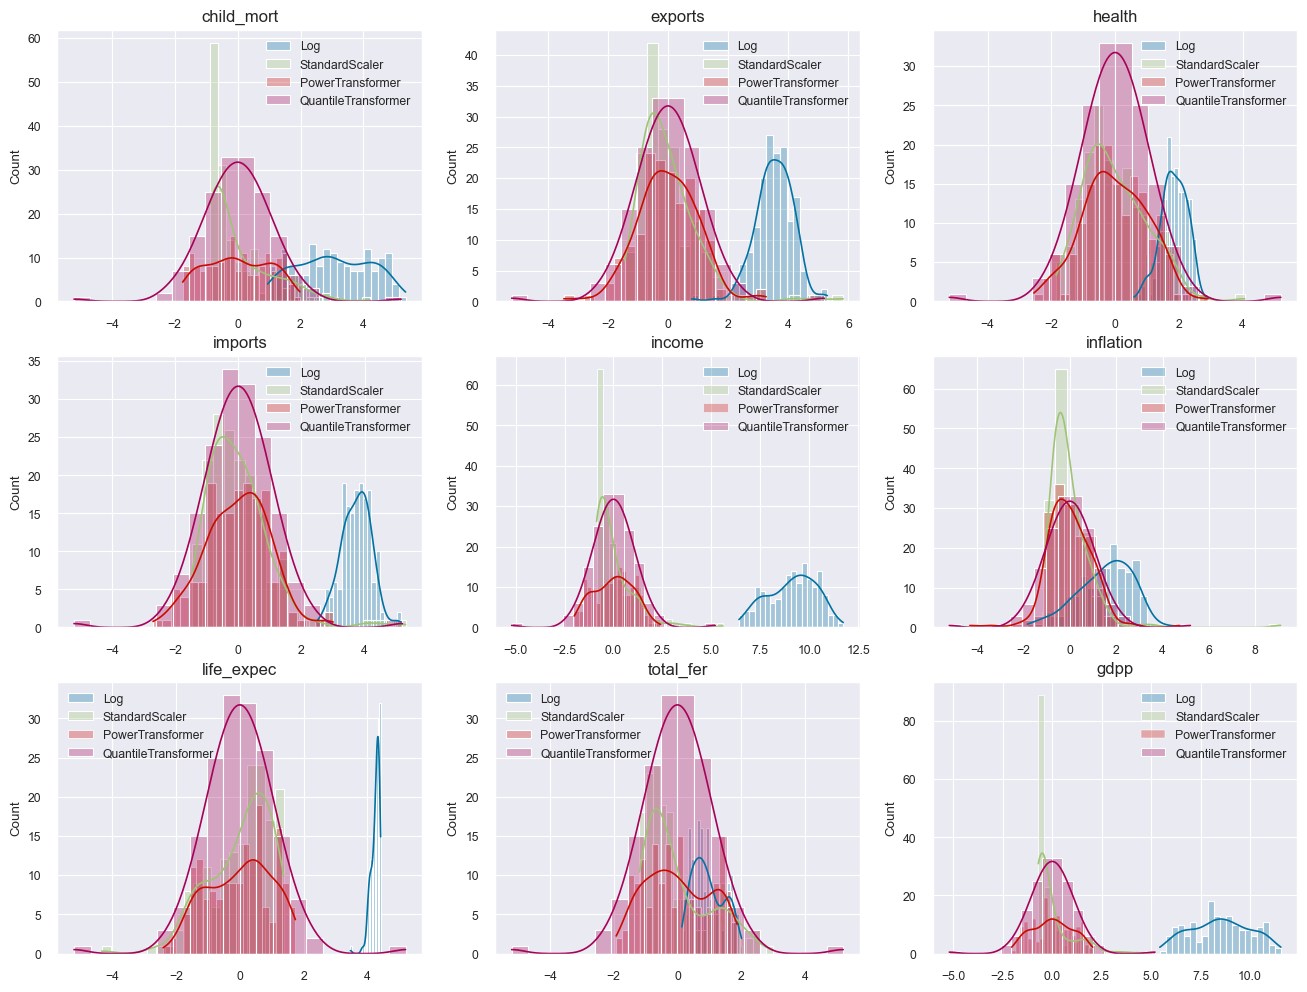

In [9]:
# Define random state
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# Define transformer objects
ss = StandardScaler()
pt = PowerTransformer()
qt = QuantileTransformer(output_distribution='normal', random_state=random_state)

# Transform data
countries_log = np.log(countries)
countries_ss = ss.fit_transform(countries)
countries_pt = pt.fit_transform(countries)
countries_qt = qt.fit_transform(countries)

# Visualize distribution of features after transformation
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
sns.set_palette('tab10')

for i, col in enumerate(countries.columns, start=1):
    plt.subplot(3, 3, i)
    sns.histplot(x=countries_log[col], bins=20, kde=True, alpha=0.3, label='Log')
    sns.histplot(x=countries_ss[:, i-1], bins=20, kde=True, alpha=0.3, label='StandardScaler')
    sns.histplot(x=countries_pt[:, i-1], bins=20, kde=True, alpha=0.3, label='PowerTransformer')
    sns.histplot(x=countries_qt[:, i-1], bins=20, kde=True, alpha=0.3, label='QuantileTransformer')
    plt.legend()
    plt.xlabel('')
    plt.title(col, fontsize=12)

**Analysis:** From the comparison between each transformation method, the one that appears to be more interesting is the Quantile Transformer, because it puts them all in a similar range and within a normal distribution. This transformation will prevent some features to be more important to the models during calculations and will avoid a biased result.

In [10]:
countries_scaled = countries_qt

---

### Principal Component Analysis (PCA)

/Users/brunomotta/miniconda3/envs/bootcamp/lib/python3.10/site-packages/paretochart/paretochart.py:198: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(yt)


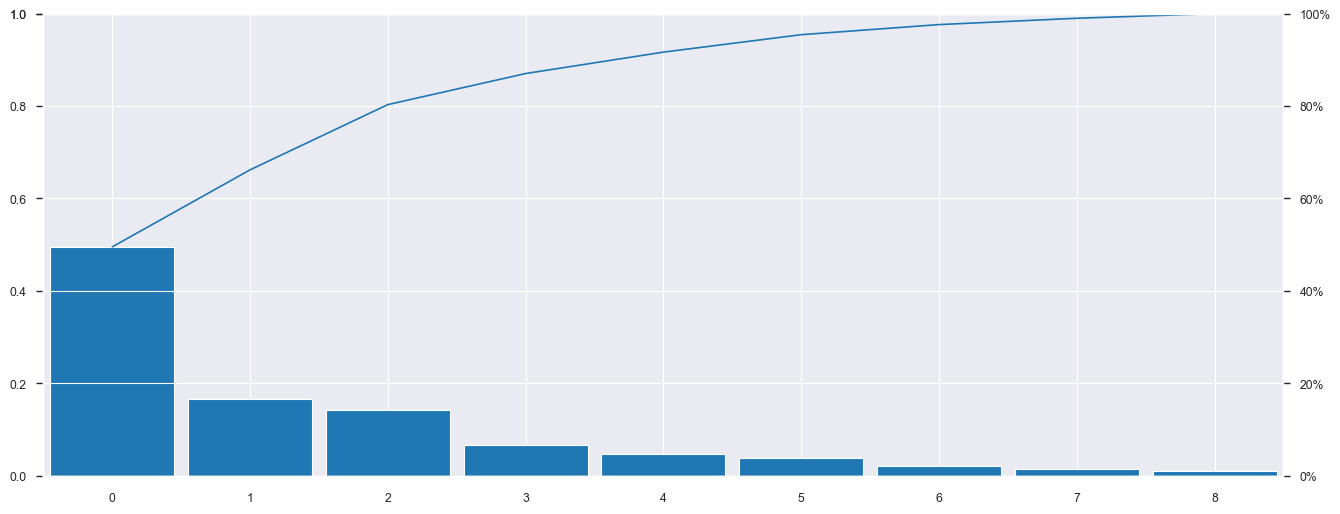

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
child_mort,-0.428836,0.128615,0.046566,0.052643,-0.248015,0.405484,-0.061660,-0.750638,-0.037829
exports,0.273711,0.552545,0.245322,-0.193490,-0.170346,-0.041828,-0.699561,0.029406,0.033722
health,0.101896,-0.215677,-0.722742,-0.541297,-0.273433,0.076580,-0.167480,-0.039167,0.132391
imports,0.107640,0.722445,-0.230729,-0.176129,0.051315,-0.182386,0.574280,-0.127758,0.014545
income,0.406402,-0.117026,0.305716,0.009010,-0.339850,0.231942,0.271442,-0.052331,0.694179
inflation,-0.246360,-0.150693,0.487093,-0.785058,0.179716,-0.106934,0.132811,-0.037137,-0.016519
life_expec,0.405879,-0.240058,-0.001177,0.058913,0.223580,-0.557037,-0.095081,-0.636241,0.006459
total_fer,-0.389945,-0.020295,0.058226,0.099584,-0.644013,-0.633833,0.027298,0.093472,0.090796
gdpp,0.420193,-0.123551,0.167163,-0.077339,-0.468546,0.132051,0.218770,-0.012856,-0.699464


In [11]:
# Fit PCA
pca = PCA(n_components=9, random_state=random_state)
pca.fit(countries_scaled)

# Visualize explained variance ratio
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
pareto(pca.explained_variance_ratio_)
plt.show()

# Dataframe with PCA components (loadings)
component_names = [f"PC{i+1}" for i in range(pca.components_.shape[0])]
X_pca = pd.DataFrame(pca.components_.T, columns=component_names, index=countries.columns)
display(X_pca)

In [12]:
explained_variances = (pca.explained_variance_ratio_.cumsum() * 100).round(2)
for c, i in enumerate(explained_variances, start=1):
    print(f'{c} components: {i}%')

1 components: 49.52%
2 components: 66.19%
3 components: 80.3%
4 components: 87.03%
5 components: 91.66%
6 components: 95.44%
7 components: 97.62%
8 components: 98.99%
9 components: 100.0%


In [13]:
# Transform data set with PCA
pca = PCA(n_components=5, random_state=random_state)
pca.fit(countries_scaled)
X_pca = pca.transform(countries_scaled)

component_names = [f"PC{i+1}" for i in range(pca.components_.shape[0])]
X_pca = pd.DataFrame(X_pca, columns=component_names, index=countries.index)
X_pca.head(10)

,PC1,PC2,PC3,PC4,PC5
country,,,,,
Afghanistan,-3.474894,-0.370200,-0.924377,-0.046801,-0.165312
Albania,0.439983,-0.164657,-0.279177,-0.003856,0.806566
Algeria,-0.388256,-0.413303,1.530128,-0.145715,0.281504
Angola,-2.453001,1.068368,2.276363,-0.435552,-1.002233
Antigua and Barbuda,1.419570,0.492511,-0.211049,0.435558,-0.131489
Argentina,-0.223601,-2.730062,0.820799,-1.041856,0.044356
Armenia,-0.336695,-0.211866,0.438980,0.300908,1.267810
Australia,2.588286,-2.591409,-0.231180,0.675071,-0.552675
Austria,3.365715,-0.419385,-0.835317,-0.219325,-0.389267


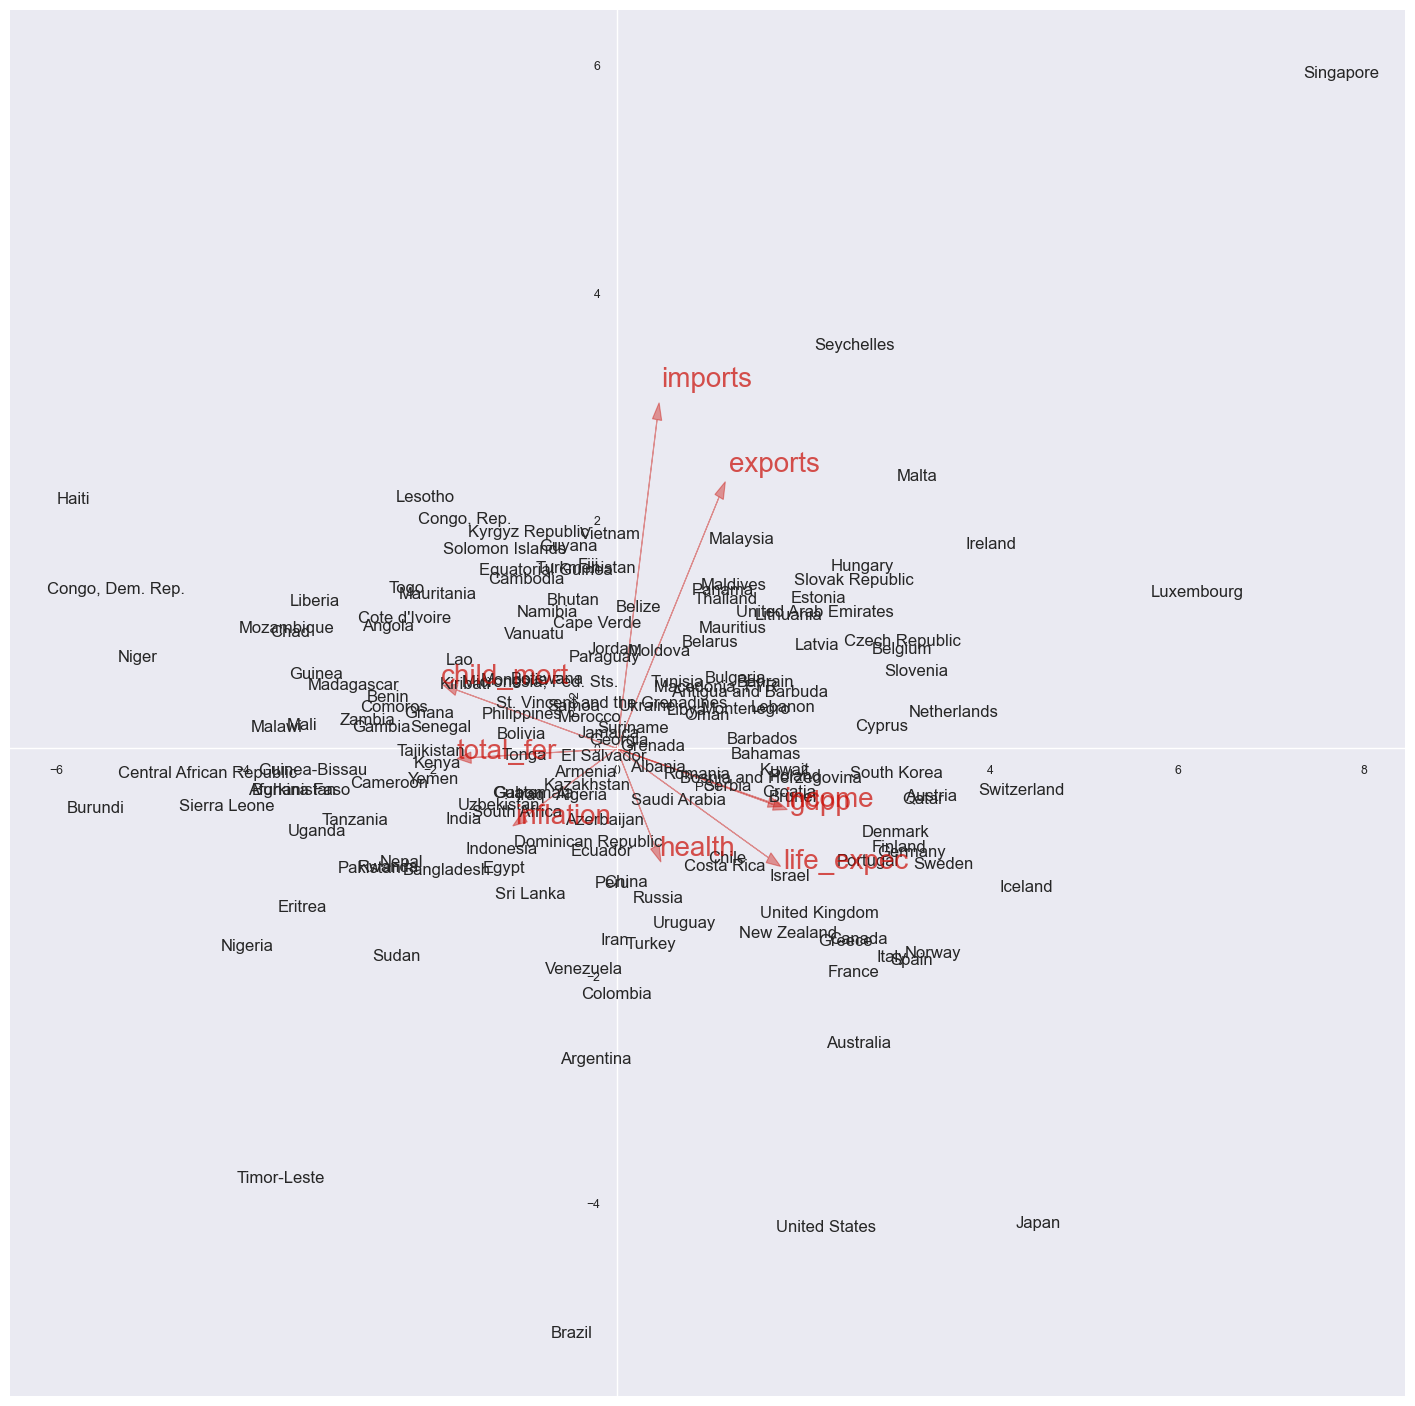

In [14]:
# Visualize components and countries distribution
plot_PCA(X_pca, countries, pca)

**Analysis:** Applying the PCA on this data set we identify that the first 3 components alone can explain 80.3% of the data. In order to have a robust clusterization, I decided to use 5 components (equivalent to 91.66% of the explained variance). Analysing the PCA1 X PCA2 plot, we can understand the features influence in each principal component and we indentify that `gdpp`, `income` and `life_expec` are highly positive influent to the PC1, in opposite to `child_mort`, `total_fer` and `inflation`. Here we start to see how our clusterization will work.

## Modeling

### K-Means

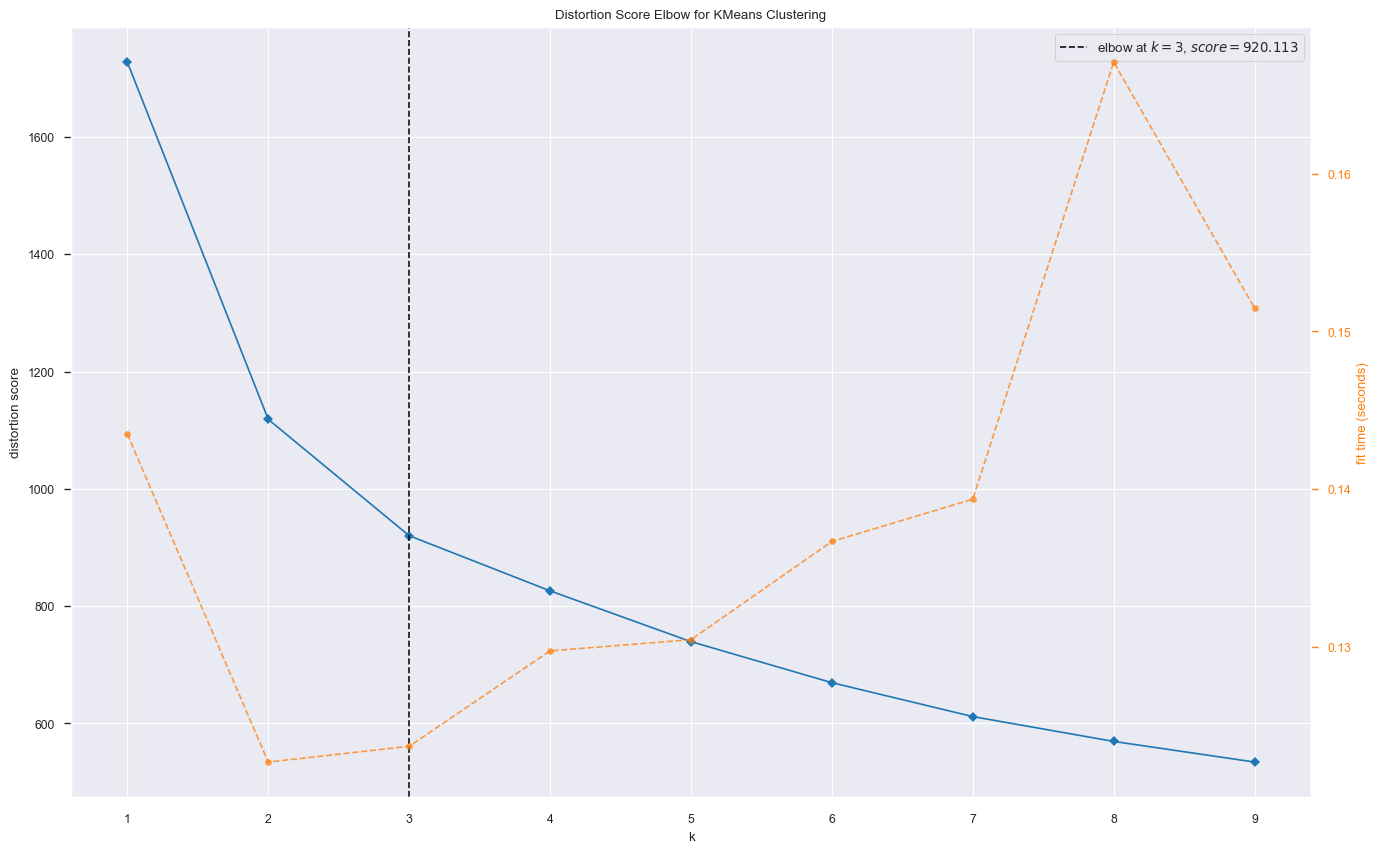

In [15]:
# Viasualize the elbow method
kmeans = KMeans(n_init=100, random_state=random_state)

fig = plt.figure(figsize=(16, 10))
ax = plt.gca()
visualizer = KElbowVisualizer(kmeans, k=(1, 10), ax=ax)
visualizer.fit(X_pca)
visualizer.show();

In [16]:
# Apply KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, n_init=100, random_state=random_state)

kmeans.fit(X_pca)
kmeans_clusters = kmeans.predict(X_pca)

countries_kmeans = countries.copy()
countries_kmeans['cluster'] = kmeans_clusters

countries_kmeans.head(10)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553,1
Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,2
Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460,2
Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,1
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200,0
Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300,2
Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220,2
Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,0
Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,0


### Hierarchical Clustering

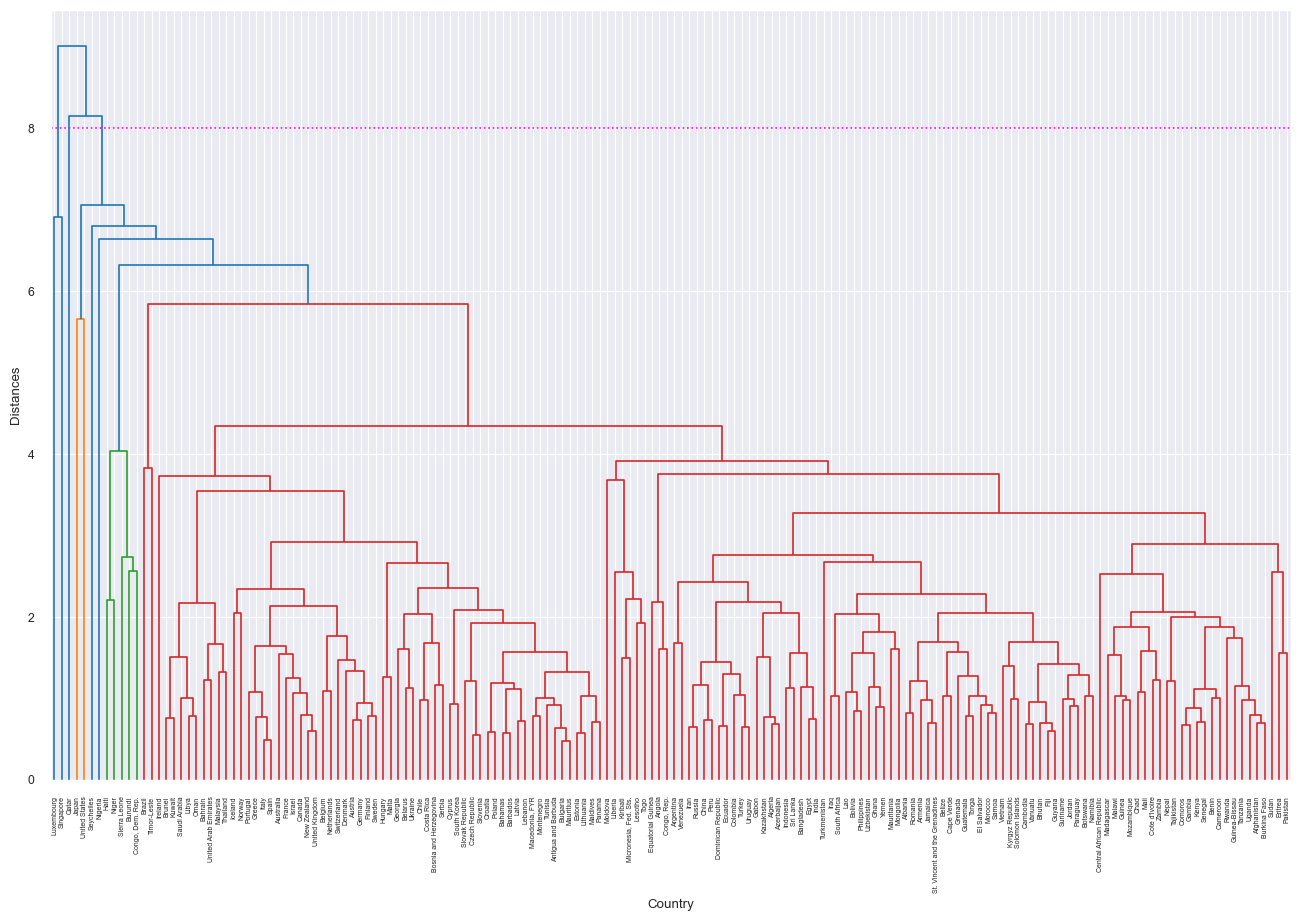

In [17]:
distance_threshold = 8

fig, ax = plt.subplots(1, 1, figsize=(16, 10))

linkage = sch.linkage(X_pca, method="average")
dendrogram = sch.dendrogram(linkage, labels=X_pca.index, leaf_rotation=90, ax=ax)
ax.set_xlabel('Country')
ax.set_ylabel('Distances')
ax.axhline(distance_threshold, color='magenta', ls=":");

In [18]:
# Getting labels from Agglomearative Hierarchical clustering
hcluster = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward', compute_distances=True)  
hcluster.fit_predict(X_pca)
hcluster_label = hcluster.labels_

countries_hcluster = countries.copy()
countries_hcluster['cluster'] = hcluster_label

countries_hcluster.head(10)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553,2
Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,0
Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460,0
Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,0
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200,1
Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300,0
Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220,0
Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,1
Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,1


## Evaluation

### K-Means

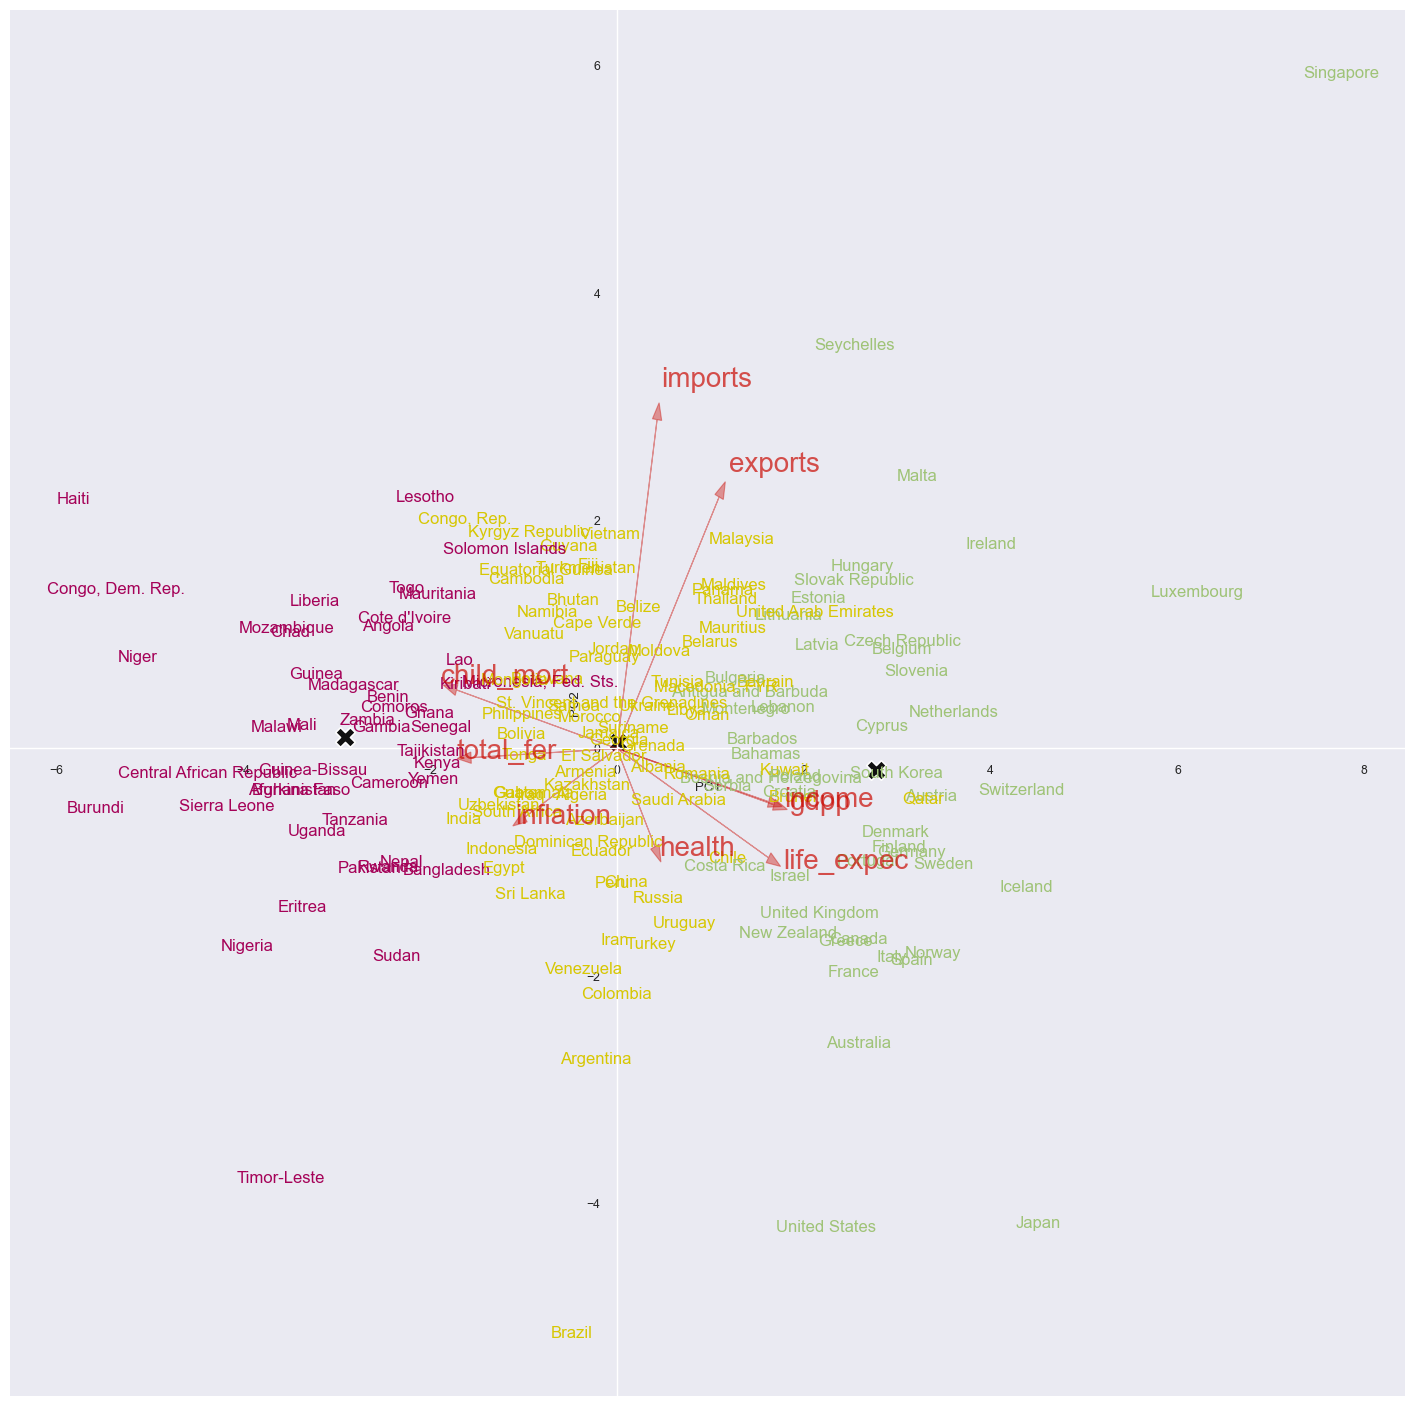

In [45]:
# Visualize clusters on PCA plot
centroids = kmeans.cluster_centers_
plot_PCA(X_pca, countries_kmeans, pca, centroids=centroids)

In [46]:
# Calculate Euclidean distances from each cluster centroid to each point
closest_points = []

for center in centroids:
    distances = np.linalg.norm(X_pca - center, axis=1)
    closest_point_idx = np.argmin(distances)
    closest_point = X_pca.iloc[closest_point_idx]
    closest_points.append(closest_point.name)

closest_points


['Austria', 'Gambia', 'Jamaica']

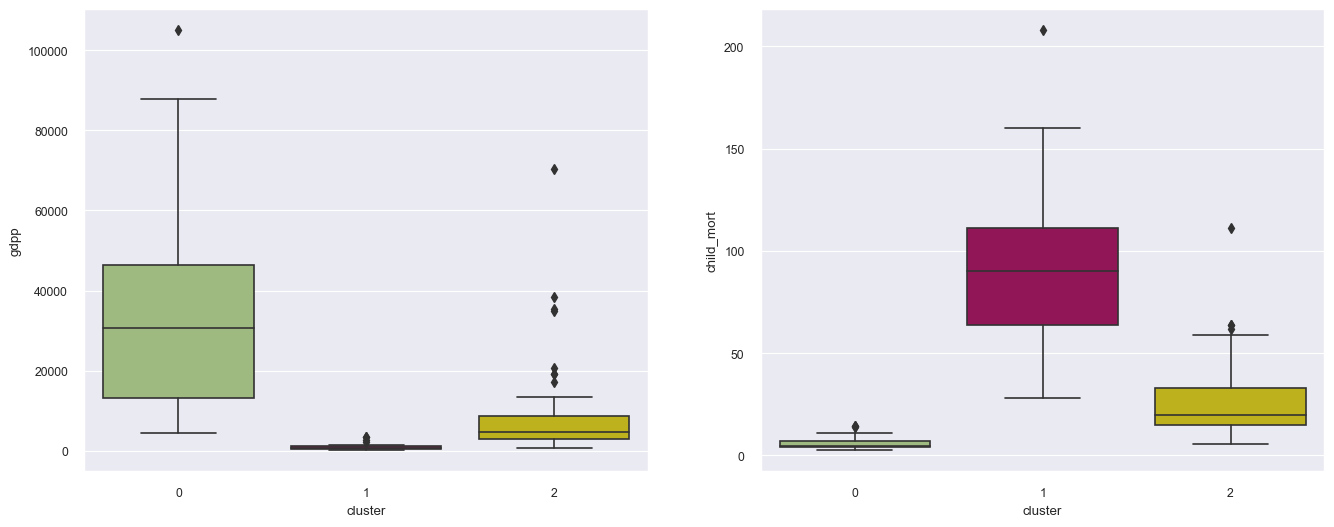

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='cluster', y='gdpp', data=countries_kmeans, ax=axs[0], palette=palette)
sns.boxplot(x='cluster', y='child_mort', data=countries_kmeans, ax=axs[1], palette=palette);

In [48]:
mapping = {0: 'Developed', 1: 'LDC', 2: 'Developing'}
countries_kmeans['dev_status'] = countries_kmeans.cluster.map(mapping)

for i, status in mapping.items():
      print(f'Number of {status} countries:', len(countries_kmeans[countries_kmeans.cluster == i]),
            '| Represented by:', closest_points[i])

Number of Developed countries: 47 | Represented by: Austria
Number of LDC countries: 45 | Represented by: Gambia
Number of Developing countries: 74 | Represented by: Jamaica


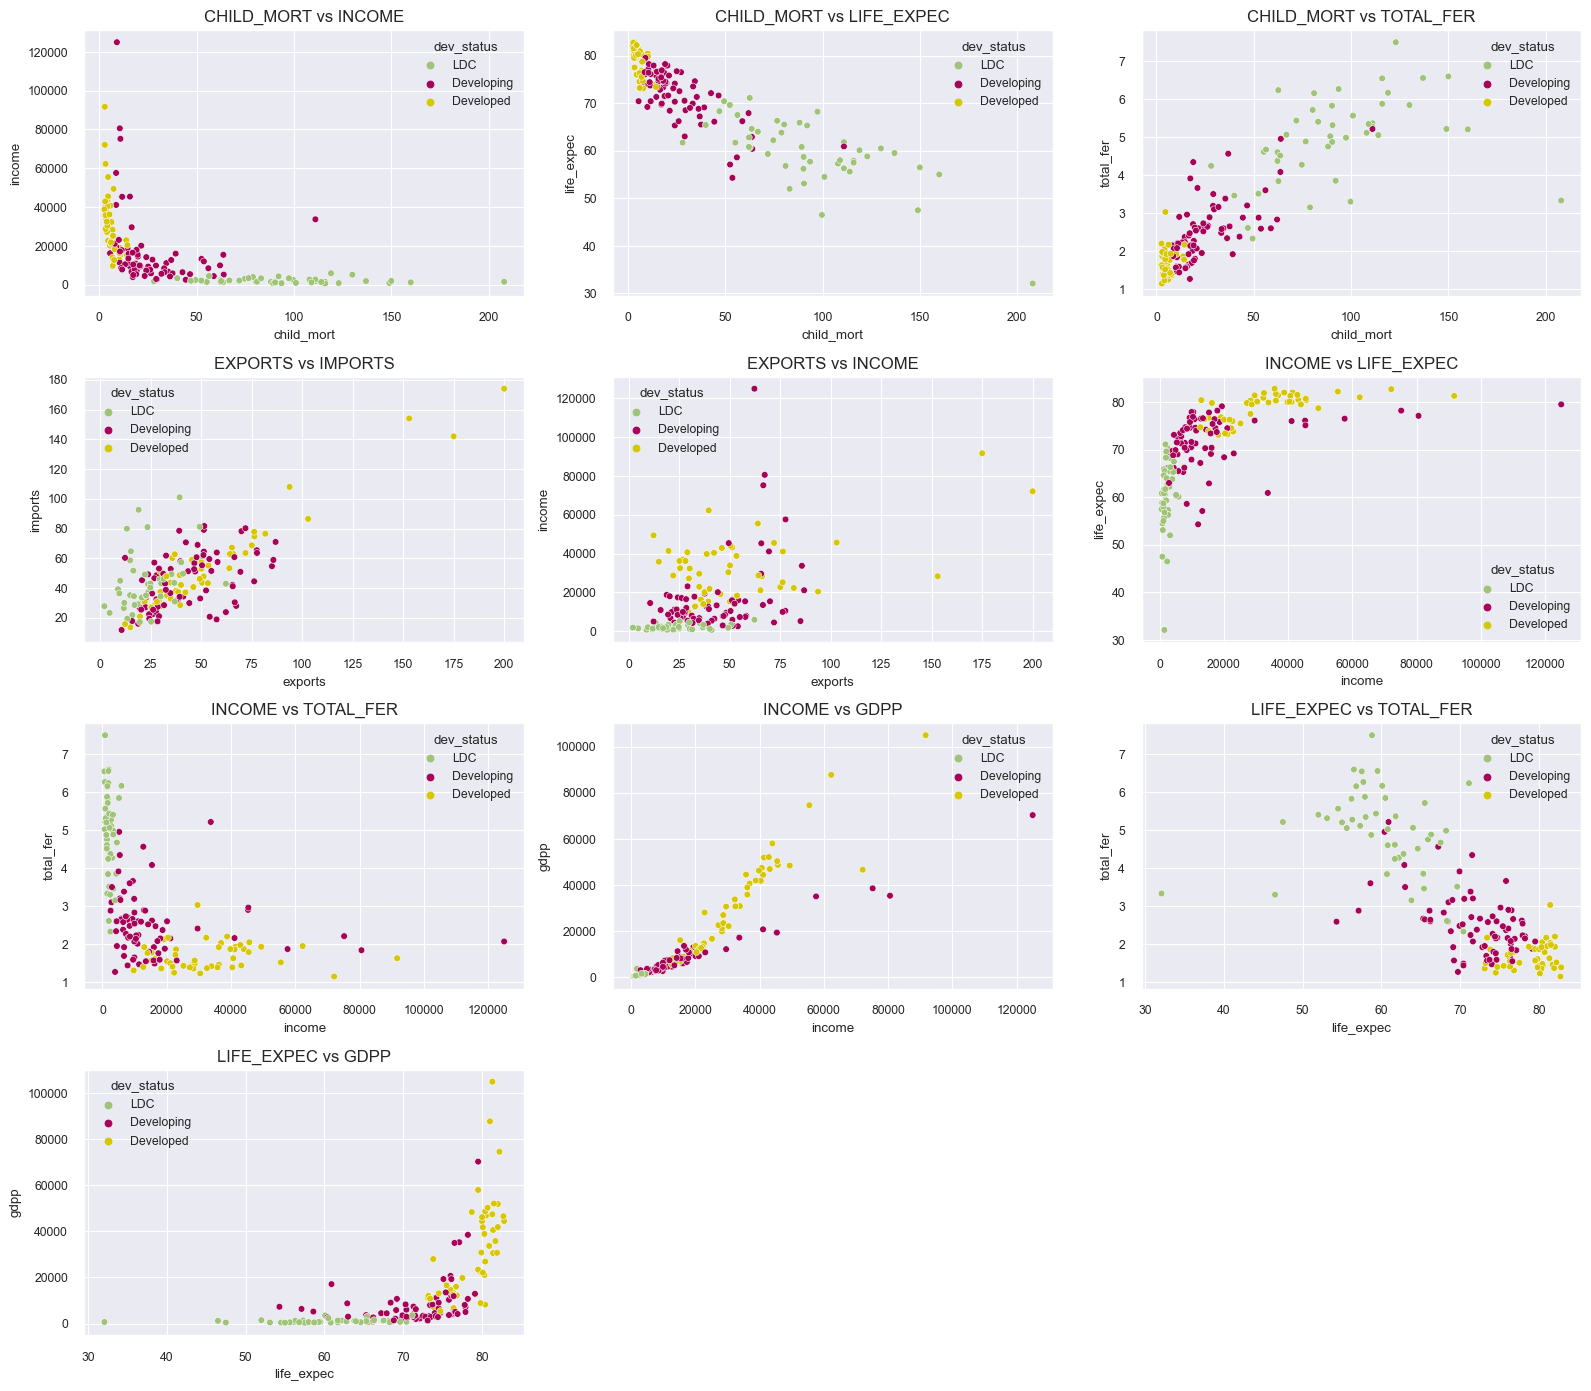

In [49]:
# Scatter Plots
scatterplot_high_corr(countries_kmeans)

In [87]:
import plotly.express as px

fig = px.choropleth(countries_kmeans['dev_status'],
                    locationmode = 'country names',
                    locations = countries_kmeans.index.values,
                    title = 'Development Countries Classification',
                    hover_name = countries_kmeans.index.values,
                    hover_data = ['dev_status'],
                    color = 'dev_status',
                    color_discrete_map = {'Developed' : 'yellow', 'Developing' : 'purple', 'LDC' : 'lightgreen'}
                   )
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')

**Analysis:** K-Means did a very interesting job clustering the countries into 3 distinct groups, using 5 PCAs for that. The distribution of the countries are mainly done by socio-economic indicators and the algorithm found what we could call the development indexes, dividing the countries into developed, developing and least developed countries (LDCs).

From the PCAs plot, we can see that the PC1 is the most important feature for the clusterization as we can notice that the groupes are well divided along its length.

While checking the `gdpp` and `child mortality` distributions by cluster, we can separate the 3 major groups defined by the algorithm and label them correctly. This way we could verify that K-Means identified:
- 47 Developed countries with Austria being the closest to the center.
- 74 Developing countries with Jamaica being the closest to the center.
- 45 Least Developed Countries with Gambia being the closest to the center.

Then I plotted again the scatter plots for the highest correlations and we can observe that for every chart the developed and LDCs are well separated while the developing countries are mostly together but with a few of them mixing with the other 2 groups in different correlations. What shows us that none of the correlations was a major influencer on the clustering, but instead all of the features mixed by the PCAs where somehow relevant.

Finally, we can see each country on the map divided by clusters in accordance to the K-Means model.

---

### Hierachical Clustering

In [51]:
# Find centroids and closest points
centroids = []
closest_points = []
for label in np.unique(hcluster_label):
    centroid = np.mean(X_pca[hcluster_label == label], axis=0)
    centroids.append(centroid.values)
    distances = [euclidean(point, centroid) for _, point in X_pca[hcluster_label == label].iterrows()]
    closest_point_idx = np.argmin(distances)
    closest_point = X_pca[hcluster_label == label].iloc[closest_point_idx]
    closest_points.append(closest_point.name)
centroids = np.array(centroids)

closest_points

['Jamaica', 'Austria', 'Gambia']

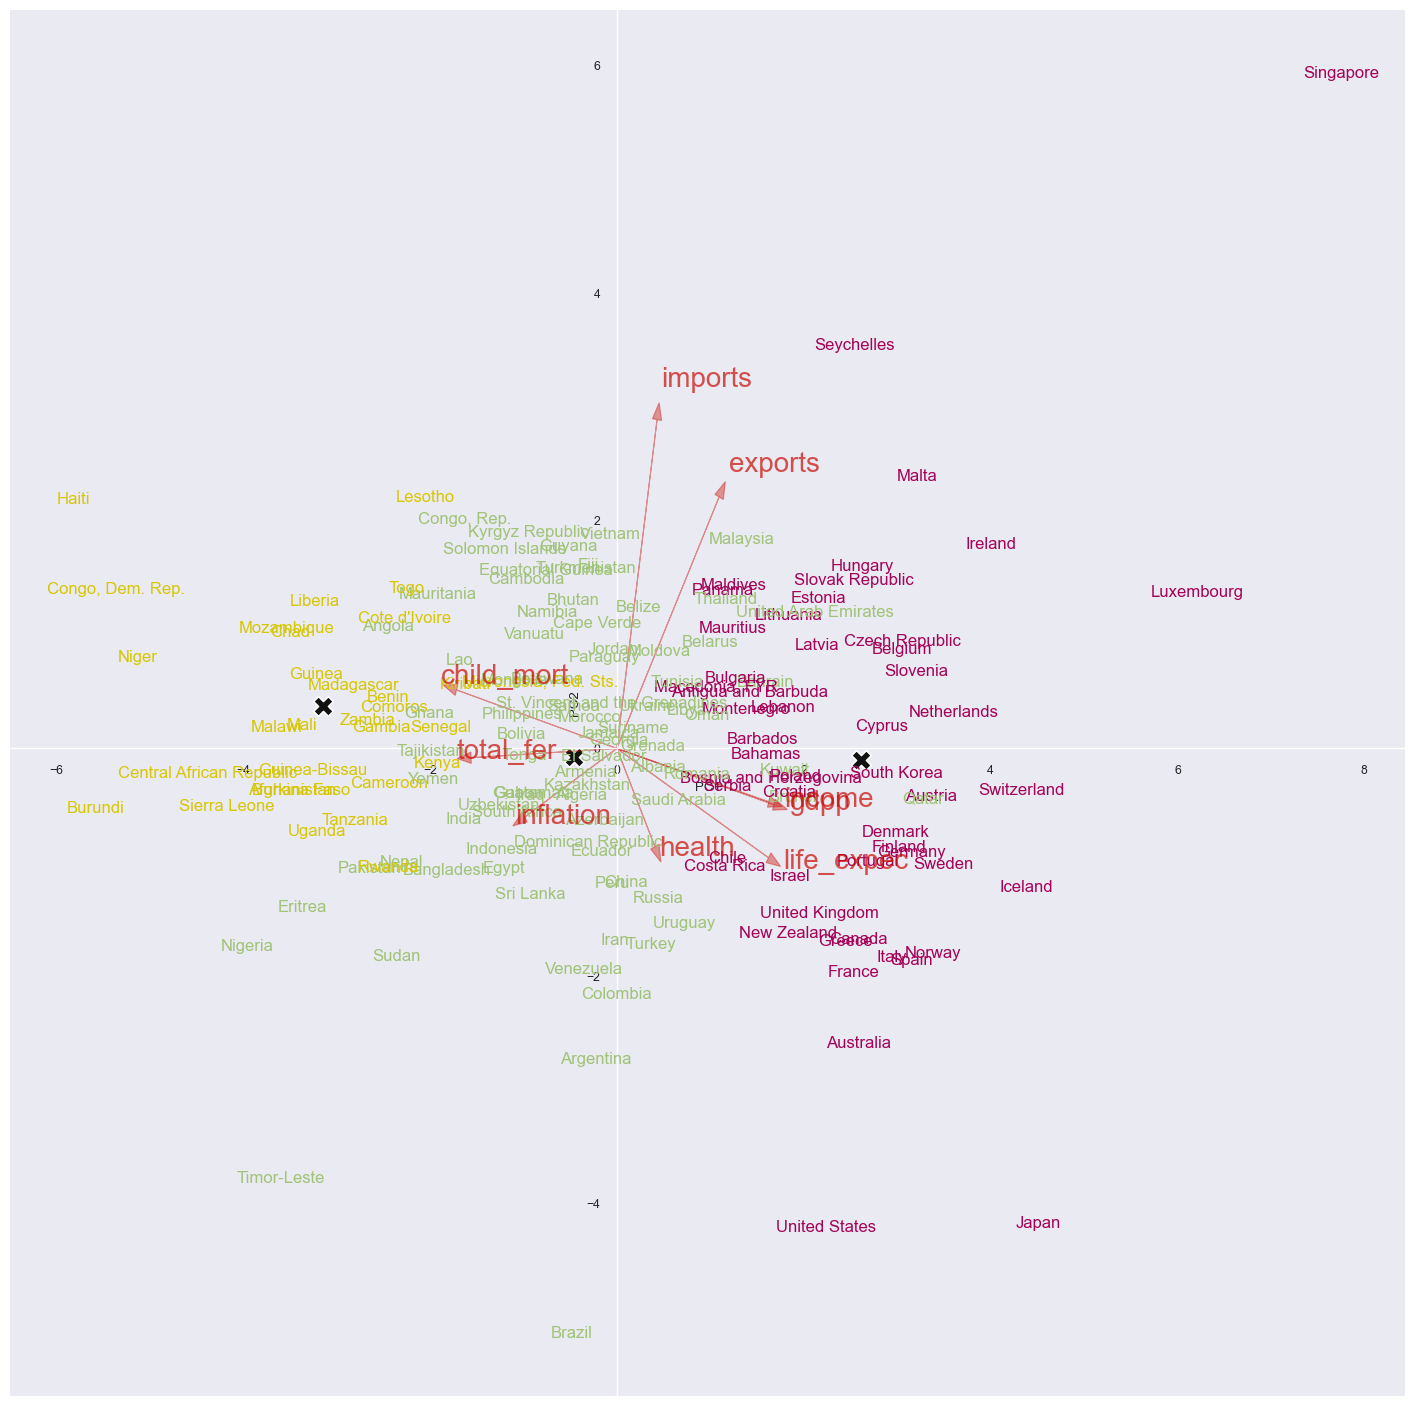

In [52]:
# Visualize clusters on PCA plot
plot_PCA(X_pca, countries_hcluster, pca, centroids=centroids)

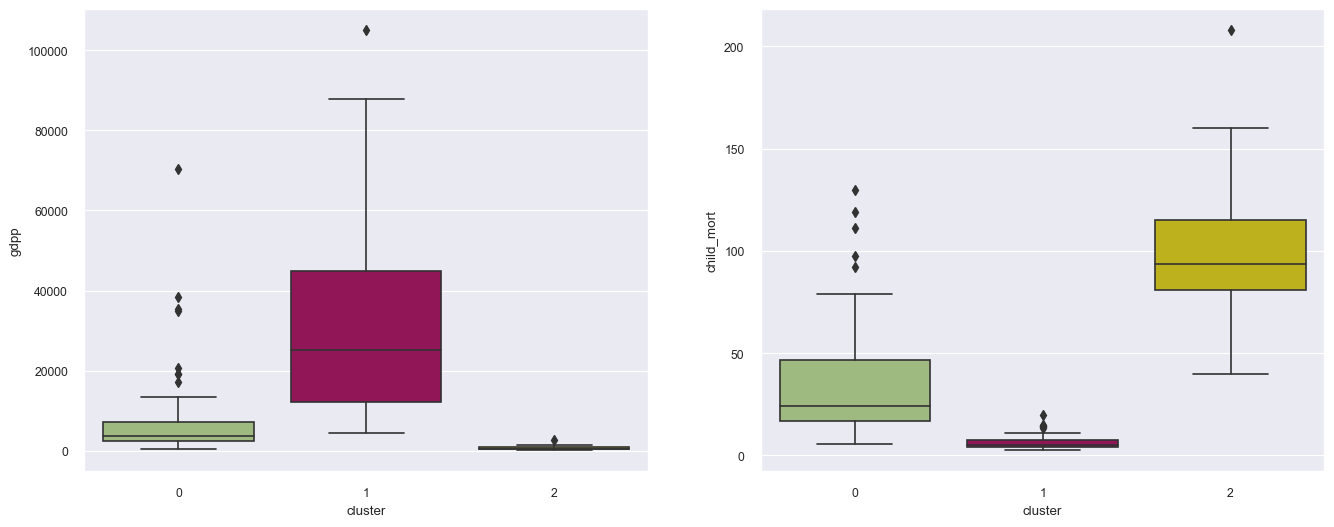

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='cluster', y='gdpp', data=countries_hcluster, ax=axs[0], palette=palette)
sns.boxplot(x='cluster', y='child_mort', data=countries_hcluster, ax=axs[1], palette=palette);

In [54]:
mapping = {0: 'Developing', 1: 'Developed', 2: 'LDC'}
countries_hcluster['dev_status'] = countries_hcluster.cluster.map(mapping)

for i, status in mapping.items():
      print(f'Number of {status} countries:', len(countries_hcluster[countries_hcluster.cluster == i]),
            '| Represented by:', closest_points[i])

Number of Developing countries: 83 | Represented by: Jamaica
Number of Developed countries: 52 | Represented by: Austria
Number of LDC countries: 31 | Represented by: Gambia


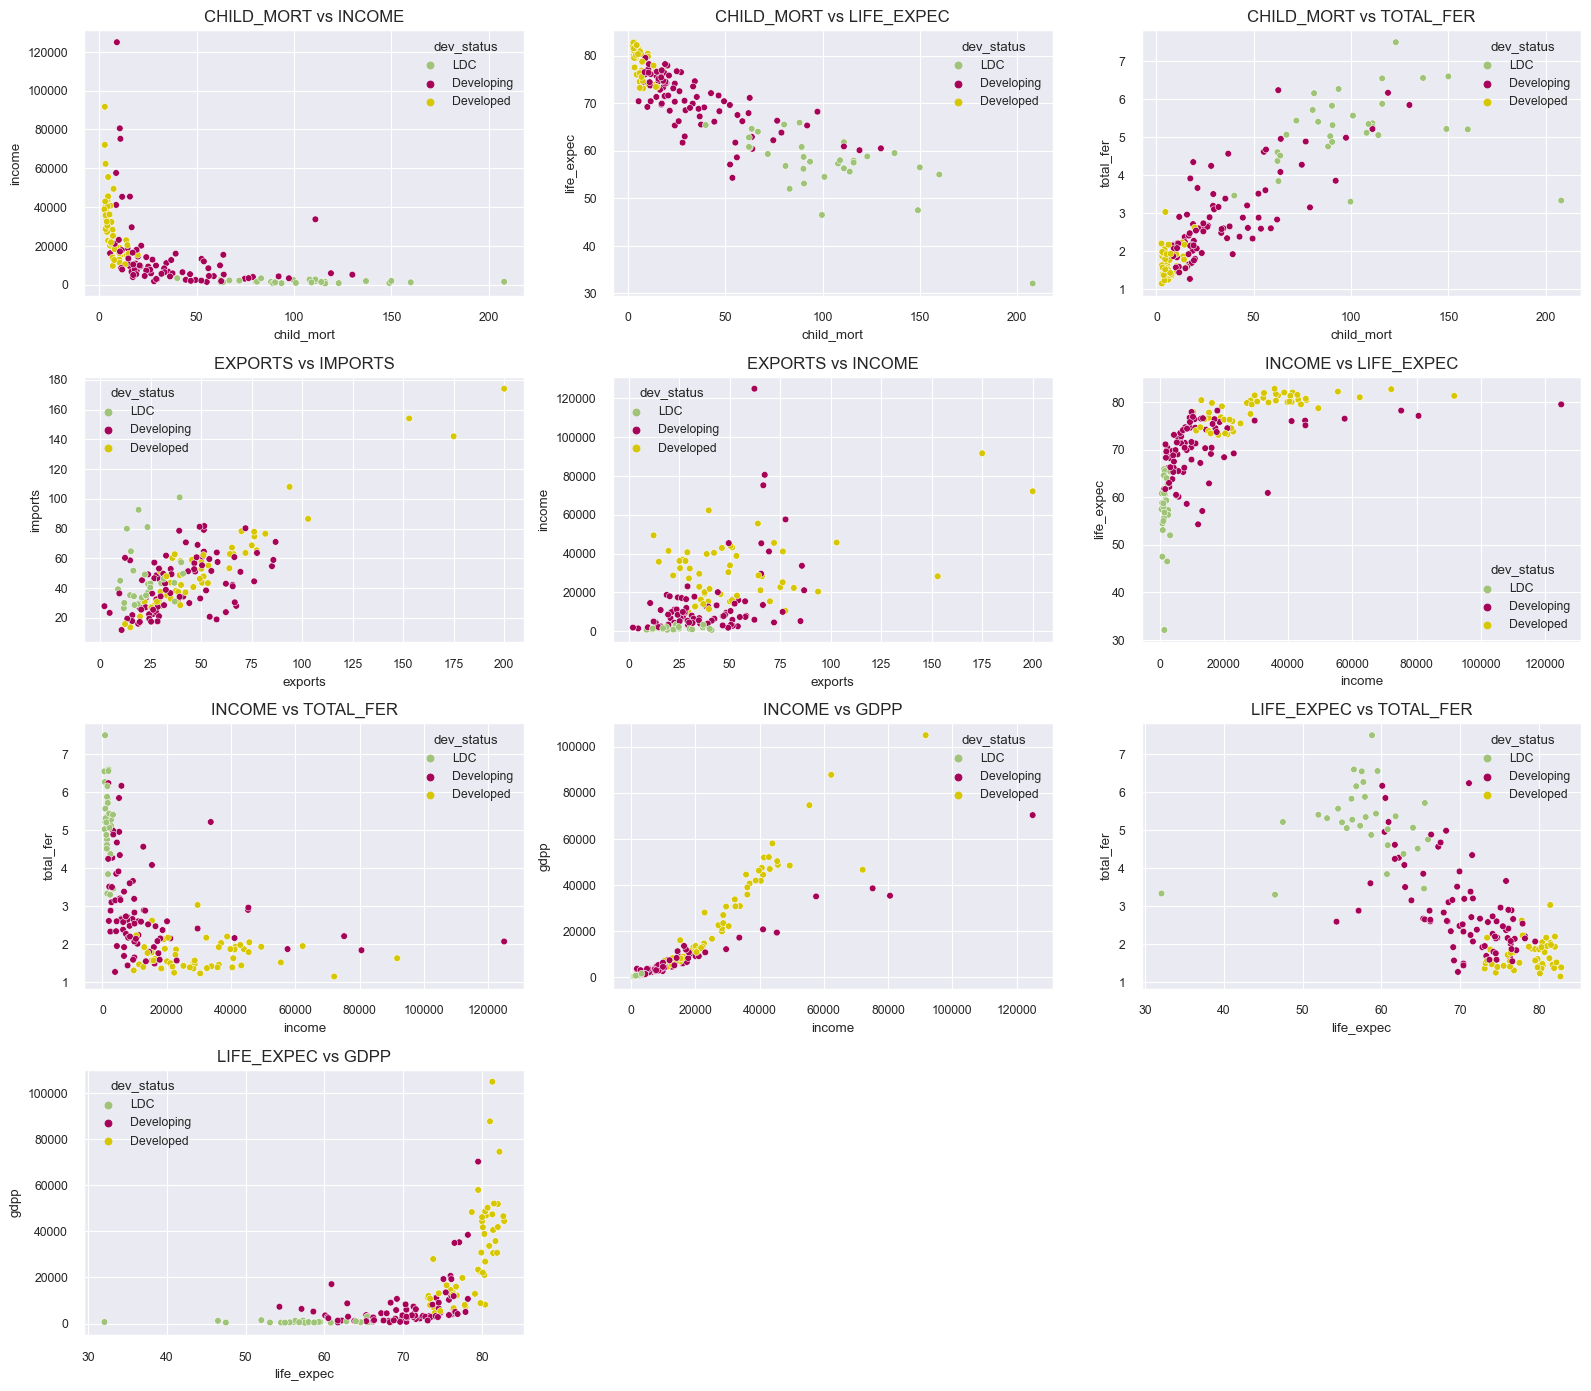

In [55]:
# Scatter Plots
scatterplot_high_corr(countries_hcluster)

In [88]:
import plotly.express as px

fig = px.choropleth(countries_hcluster['dev_status'],
                    locationmode = 'country names',
                    locations = countries_hcluster.index.values,
                    title = 'Development Countries Classification',
                    hover_name = countries_hcluster.index.values,
                    color = 'dev_status',
                    color_discrete_map = {'Developed' : 'yellow', 'Developing' : 'purple', 'LDC' : 'lightgreen'}
                   )
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')

**Analysis:** Comparing Hierarchical Clustering with K-means, we can note that there are some differences in the groupes. This algorithm divided the countries within the following:
- Developed countries: 52, represented by: Austria
- Developing countries: 83, represented by: Jamaica
- LDC countries: 31, represented by: Gambia

Looking at the scatter plots we can find a more significant mix between the groups, what makes us believe that this model had more trouble trying to separate the countries.

And when we go to the map, besides it looks a lot like the other one, we can still find some differences.